## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [59]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [60]:
train, test = keras.datasets.cifar10.load_data()

In [61]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [62]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [63]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [64]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [65]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_weights, gamma=2., alpha=4.):
    """Define the customized loss."""
    
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        
        return tf.reduce_mean(reduced_fl) * (1- ce_weights) + ce_loss * ce_weights

    return ce_focal_loss_fixed
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [66]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp- %s, ce_weight: %.2f" % (i, ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (

Epoch 11/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.2043 - accuracy: 0.6183 - val_loss: 3.1861 - val_accuracy: 0.4819
Epoch 12/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.1139 - accuracy: 0.6305 - val_loss: 3.1760 - val_accuracy: 0.4855
Epoch 13/25
50000/50000 [==============================] - 8s 157us/step - loss: 2.0198 - accuracy: 0.6450 - val_loss: 3.1572 - val_accuracy: 0.4891
Epoch 14/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.9270 - accuracy: 0.6589 - val_loss: 3.2089 - val_accuracy: 0.4810
Epoch 15/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.8407 - accuracy: 0.6717 - val_loss: 3.2121 - val_accuracy: 0.4889
Epoch 16/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.7521 - accuracy: 0.6847 - val_loss: 3.2433 - val_accuracy: 0.4879
Epoch 17/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6745 - accuracy: 0.6948

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 3.4084 - accuracy: 0.3016 - val_loss: 3.4891 - val_accuracy: 0.1901
Epoch 2/25
50000/50000 [==============================] - 7s 135us/step - loss: 2.5666 - accuracy: 0.4183 - val_loss: 3.0563 - val_accuracy: 0.3268
Epoch 3/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.3473 - accuracy: 0.4601 - val_loss: 2.7368 - val_accuracy: 0.3946
Epoch 4/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.2150 - accuracy: 0.4880 - val_loss: 2.5223 - val_accuracy: 0.4375
Epoch 5/25
50000/50000 [==============================] - 7s 147us/step - loss: 2.1163 - accuracy: 0.5075 - val_loss: 2.4188 - val_accuracy: 0.4480
Epoch 6/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.0349 - accuracy: 0.5255 - val_loss: 2.3141 - val_accuracy: 0.4582
Epoch 7/25
50000/50000 [==============================] - 7s 1

Epoch 21/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.0202 - accuracy: 0.6534 - val_loss: 1.4443 - val_accuracy: 0.4969
Epoch 22/25
50000/50000 [==============================] - 7s 140us/step - loss: 0.9998 - accuracy: 0.6624 - val_loss: 1.4512 - val_accuracy: 0.4935
Epoch 23/25
50000/50000 [==============================] - 7s 144us/step - loss: 0.9783 - accuracy: 0.6700 - val_loss: 1.4492 - val_accuracy: 0.4973
Epoch 24/25
50000/50000 [==============================] - 7s 140us/step - loss: 0.9569 - accuracy: 0.6783 - val_loss: 1.4597 - val_accuracy: 0.4960
Epoch 25/25
50000/50000 [==============================] - 7s 143us/step - loss: 0.9355 - accuracy: 0.6859 - val_loss: 1.4517 - val_accuracy: 0.5010


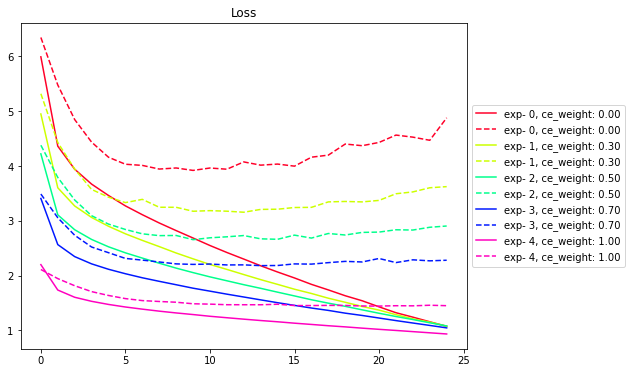

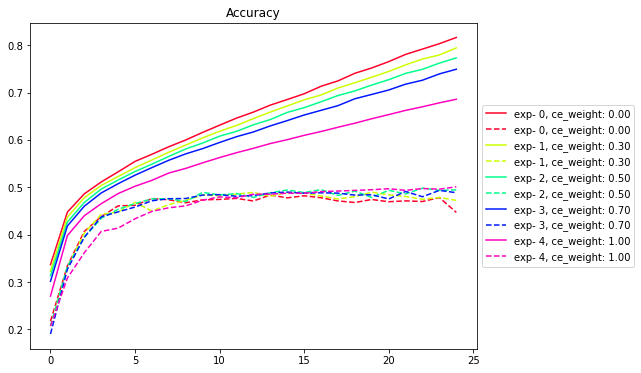

In [67]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()